In [1]:
!nvidia-smi

zsh:1: command not found: nvidia-smi


## Roberta Base Model

In [2]:
import os
import pandas as pd
import numpy as np

import torch
from torch.utils.data import Dataset, DataLoader, random_split

from transformers import AutoTokenizer, AutoModel

In [3]:
# setting the model name
PRE_TRAINED_MODEL_NAME = 'roberta-base'

# setting the dataset
dataset='MBTI 500 multi_label.csv'


# setting the data path
if os.path.exists(f'/datasets/mbti/{dataset}'):
    DATAPATH=f'/datasets/mbti/{dataset}'
else:
    DATAPATH=f'../data/{dataset}'

# setting the checkpoint path 
if os.path.exists('ckpts'):
    CHECKPOINTPATH = 'ckpts/Persnality_MBTI_clean'
else:
    CHECKPOINTPATH = '../ckpts/Persnality_MBTI_clean'

# training parameters
MAX_LEN = 512
TRAIN_BATCH_SIZE = 20
VALID_BATCH_SIZE = 16
TEST_BATCH_SIZE = 16
EPOCHS = 10
THRESHOLD = 0.5 # threshold for the sigmoid function

# TOKENIZER
tokenizer = AutoTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

# setting the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# setting the random seed
torch.manual_seed(99)
torch.cuda.manual_seed(99)
torch.cuda.manual_seed_all(99)
np.random.seed(99)

In [4]:
DATAPATH,CHECKPOINTPATH

('../data/MBTI 500 multi_label.csv', '../ckpts/Persnality_MBTI_clean')

### Loading the Data

In [5]:
# load the data
data = pd.read_csv(DATAPATH,encoding='utf-8')

In [6]:
# delete the words in the words list from the posts column
words=[" intj"," intp"," entj"," entp"," infj"," infp"," enfj"," enfp"," istj"," isfj"," estj"," esfj"," istp"," isfp"," estp"," esfp", " introvert", " extrovert", " intuitive", " observant", " thinking", " feeling", " judging", " preceiving"]

def delete_words(data, words):
    for word in words:
        data['posts'] = data['posts'].str.replace(word, '')
    return data

data = delete_words(data, words)

In [7]:
# create the dataset class
class MBTIDataset(Dataset):
    def __init__(self, data, labels_list, tokenizer, max_len):
        self.data = data
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.targets = self.data[labels_list].values
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        text=self.data.posts[index]
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=True,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
            truncation=True,
        )
        return {
            'text': text,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'token_type_ids': encoding['token_type_ids'].flatten(),
            'targets': torch.tensor(self.targets[index], dtype=torch.float)
        }

In [8]:
# get the labels list
labels_list = data.columns[2:].tolist()
print(f'Labels list: {labels_list}')

Labels list: ['IE', 'NS', 'TF', 'JP']


In [9]:
# create the dataset
dataset = MBTIDataset(data, labels_list, tokenizer, MAX_LEN)

# split the data
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# create the data loaders
train_data_loader = DataLoader(train_dataset, batch_size=TRAIN_BATCH_SIZE, shuffle=True)
val_data_loader = DataLoader(val_dataset, batch_size=VALID_BATCH_SIZE, shuffle=True)
test_data_loader = DataLoader(test_dataset, batch_size=TEST_BATCH_SIZE, shuffle=True)

### Model

In [10]:
class ROBERTAClass(torch.nn.Module):
    def __init__(self, PRE_TRAINED_MODEL_NAME, num_classes=4, dropout=0.3):
        super(ROBERTAClass, self).__init__()
        self.bert_model = AutoModel.from_pretrained(PRE_TRAINED_MODEL_NAME, return_dict=True, output_attentions=True)
        self.dropout = torch.nn.Dropout(dropout)
        self.linear = torch.nn.Linear(768, num_classes)
    def forward(self, input_ids, attention_mask, token_type_ids):
        output = self.bert_model(
            input_ids, 
            attention_mask=attention_mask, 
            token_type_ids=token_type_ids
        )
        output_dropout = self.dropout(output.pooler_output)
        output = self.linear(output_dropout)
        return output
    def getProbabilities(self, input):
        input=input.tolist()
        input = tokenizer(input , max_length=512, truncation=True, padding='longest', return_token_type_ids=True, return_tensors='pt')
        input = {key: tensor.to(device) for key, tensor in input.items()}
        output=self.forward(**input)
        probabilities=torch.sigmoid(output)
        return probabilities
    def getBinaryProbs(self,input):
        probabilities=self.getProbabilities(input)
        IE = []
        NS=[]
        TF=[]
        JP=[]
        # Iterate over each item in the probabilities tensor
        for prob in probabilities:
        # Apply the transformation to each item and directly append to the list
            IE.append(torch.tensor([1 - prob[0], prob[0]]))
            NS.append(torch.tensor([1 - prob[1], prob[1]]))
            TF.append(torch.tensor([1 - prob[2], prob[2]]))
            JP.append(torch.tensor([1 - prob[3], prob[3]]))

        # Convert the list of tensors to a single tensor
        IE = torch.stack(IE)
        NS= torch.stack(NS)
        TF= torch.stack(TF)
        JP= torch.stack(JP)
        return IE, NS, TF, JP

#### Load the model

In [11]:
model = ROBERTAClass(PRE_TRAINED_MODEL_NAME)
model.load_state_dict(torch.load(CHECKPOINTPATH + f'_Best_{PRE_TRAINED_MODEL_NAME}.bin', map_location=torch.device(device)))
model.to(device)
print(f'{PRE_TRAINED_MODEL_NAME} loaded')
model.eval()
torch.set_grad_enabled(False)

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


roberta-base loaded


### SHAP

In [12]:
import shap
shap.initjs()

### Introvert / Extrovert Explainer

In [13]:
def get_IE_Explaination(input):
    IE,_,_,_= model.getBinaryProbs(input)
    return IE
class_names=["Introvert", "Extrovert"]
IE_Explainer=shap.Explainer(get_IE_Explaination,masker=shap.maskers.Text(), output_names=class_names)

In [14]:
def get_IE_Explaination(input):
    IE,_,_,_= model.getBinaryProbs(input)
    return IE
class_names=["Introvert", "Extrovert"]
IE_Explainer=shap.Explainer(get_IE_Explaination,masker=shap.maskers.Text(), output_names=class_names)

In [15]:
test="U.S. students flunk algebra more than any other course—but one middle school in Southern California is working to change that with a new approach to teaching math that involves McDonald’s and movie theater popcorn."
# one of bill gates recent tweets
shap_values= IE_Explainer([test])

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:12, 12.86s/it]               


In [16]:
model.getProbabilities(np.array([test]))

tensor([[0.2621, 0.1279, 0.2973, 0.5377]])

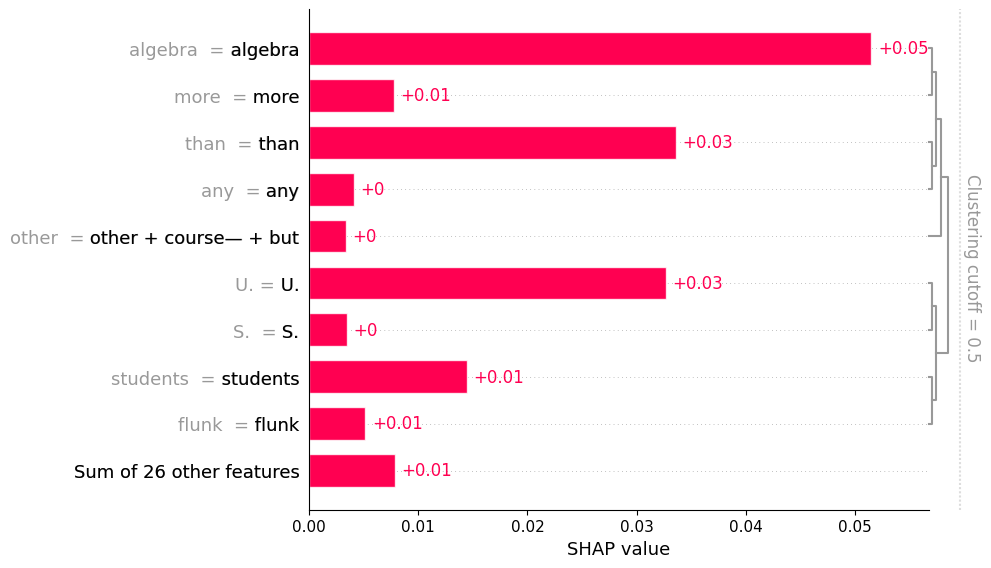

In [17]:
shap.plots.bar(shap_values[0,:,0])

In [18]:
shap.plots.text(shap_values)

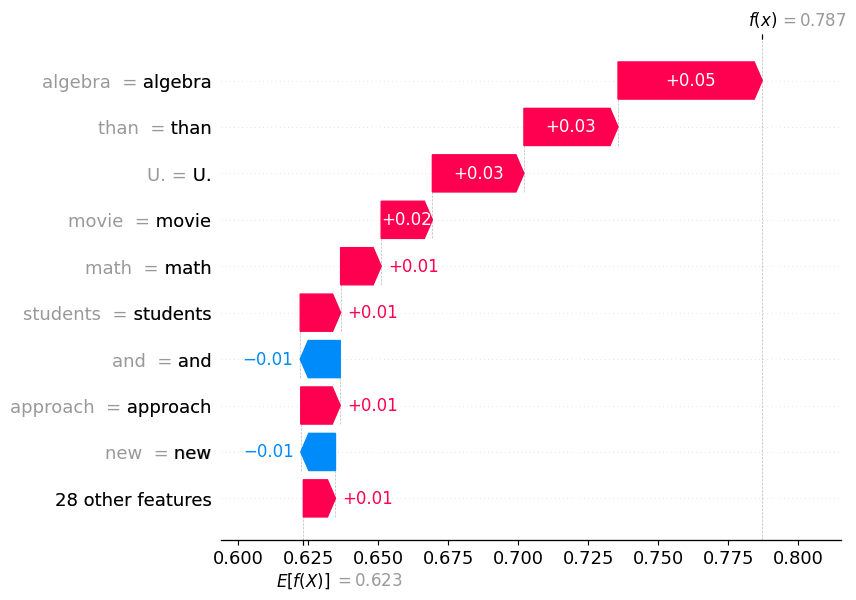

In [19]:
shap.plots.waterfall(shap_values[0,:,0])

### Intuition/Sensing

In [20]:
def get_NS_Explaination(input):
    _,NS,_,_= model.getBinaryProbs(input)
    return NS
class_names=["Intuition", "Sensing"]
NS_Explainer=shap.Explainer(get_NS_Explaination,masker=shap.maskers.Text(), output_names=class_names)

In [21]:
shap_values= NS_Explainer([test])

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:10, 10.67s/it]               


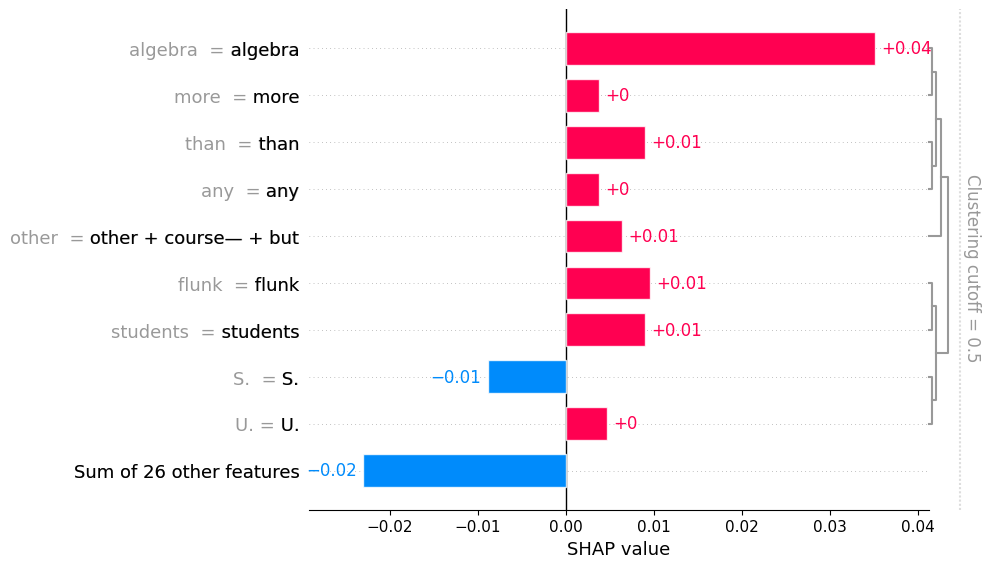

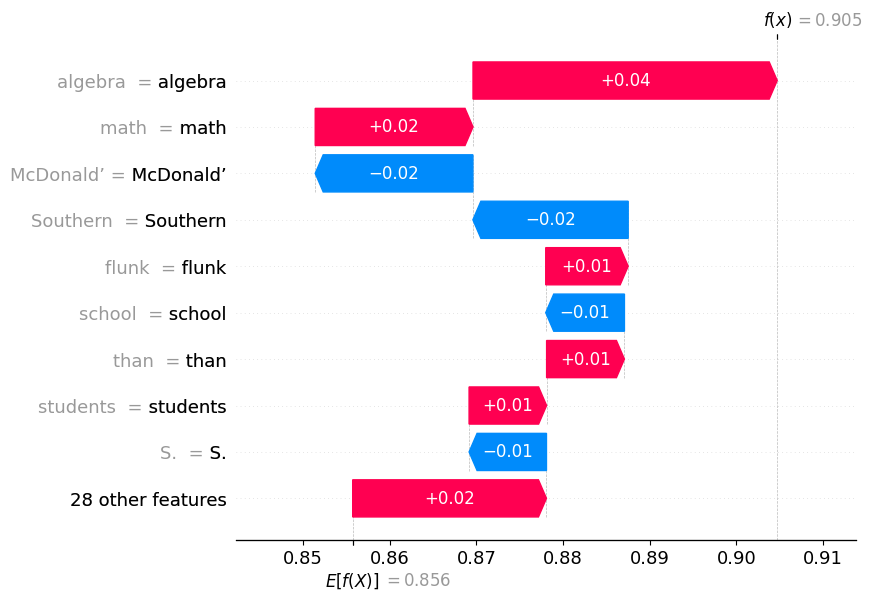

In [22]:
shap.plots.bar(shap_values[0,:,0])
shap.plots.text(shap_values)
shap.plots.waterfall(shap_values[0,:,0])

### Thinking/Feeling

In [23]:
def get_TF_Explaination(input):
    _,_,TF,_= model.getBinaryProbs(input)
    return TF
class_names=["Thinking", "Feeling"]
TF_Explainer=shap.Explainer(get_TF_Explaination,masker=shap.maskers.Text(), output_names=class_names)

In [24]:
shap_values= TF_Explainer([test])

  0%|          | 0/498 [00:00<?, ?it/s]

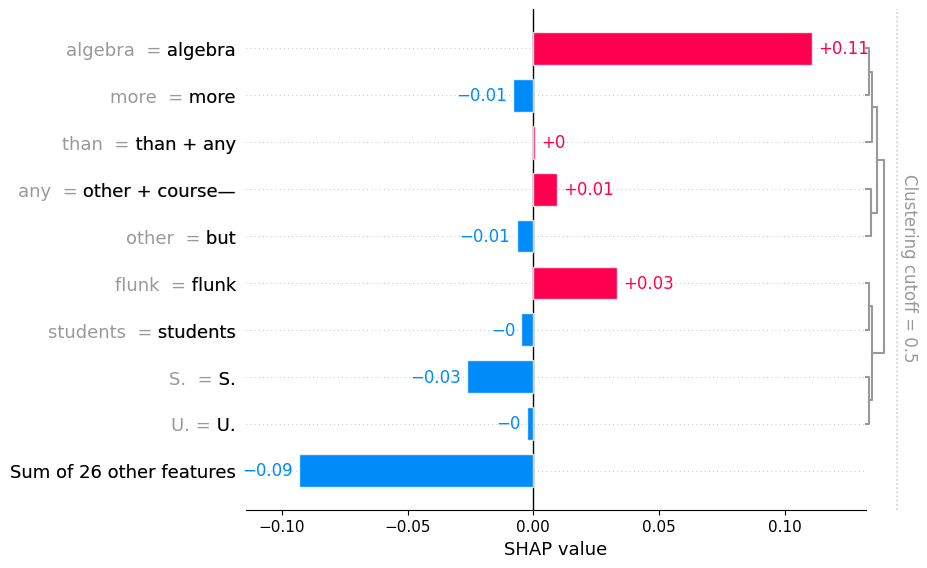

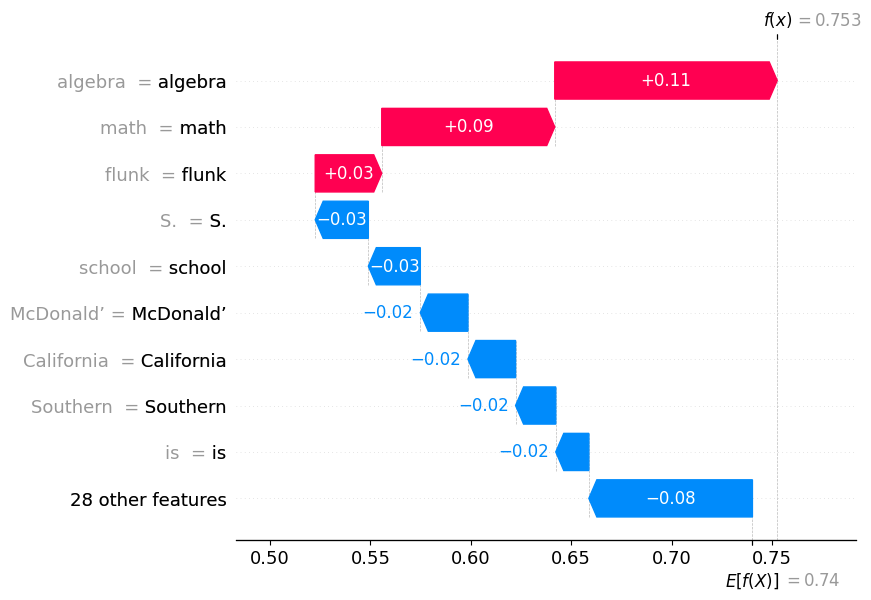

In [25]:
shap.plots.bar(shap_values[0,:,0])
shap.plots.text(shap_values)
shap.plots.waterfall(shap_values[0,:,0])

### Judging/Perceiving

In [26]:
def get_JP_Explaination(input):
    _,_,_,JP= model.getBinaryProbs(input)
    return JP
class_names=["Judging", "Preceiving"]
JP_Explainer=shap.Explainer(get_JP_Explaination,masker=shap.maskers.Text(), output_names=class_names)

In [27]:
shap_values= JP_Explainer([test])

  0%|          | 0/498 [00:00<?, ?it/s]

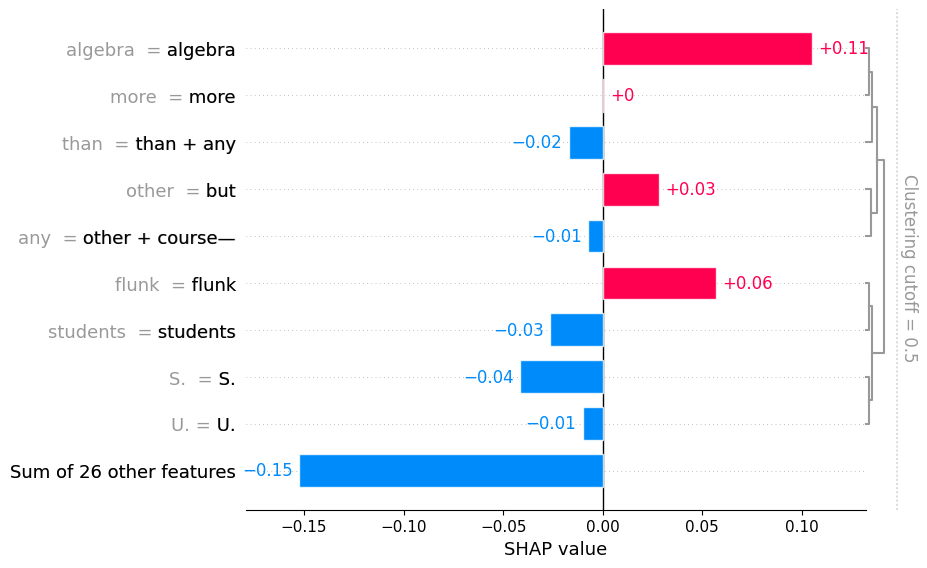

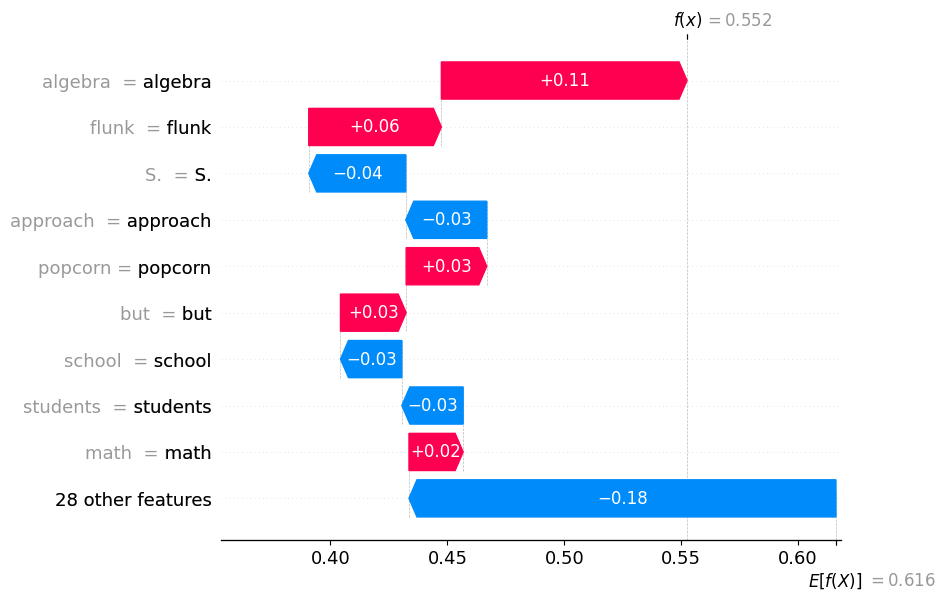

In [29]:
shap.plots.bar(shap_values[0,:,1])
shap.plots.text(shap_values)
shap.plots.waterfall(shap_values[0,:,1])